In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time

C:\Users\gails\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Define ODE & parameter ranges

In [3]:
def dNdt(t, N, r, γ, β, α1, α2, α3, μ, pM, pT):
    
    C,M,T = N
    
    dC = (r*C*(1-C-M-T) + α1*r*C*T - α3*γ*C*M - μ*C)*dt
    dM = (γ*M*(1-C-M-T) + α2*γ*T*M + α3*γ*C*M - pM*M)*dt
    dT = (β*T*(1-C-M-T) - α1*r*C*T - α2*γ*T*M - pT*T)*dt

    return dC, dM, dT

# Alternative Stable State (AltSS) Search
### I used applicable parameter values from Fung et al., 2011 Fig. 3C (which yielded AltSS)

In [4]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

pM_val = np.linspace(0.05, 0.15, 10)
pM_val_subrange = np.linspace(0.11, 0.13, 5)

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
       1.000e+04])

#### Test all combinations of intial state values (C0, M0, T0) at increasing rates of macroalgal mortality (pM)

In [7]:
def AltSS_pM(): 
    
    outputs = []
    outputs_prime = []
    
    for pM in pM_val_subrange:

        for C0 in np.linspace(0,1,11):
            
            for M0 in np.linspace(0,1,11):
            
                for T0 in np.linspace(0,1,11):
            
                    r = 0.2
                    γ = 0.35
                    β = 5
                    α1 = 0.25
                    α2 = 0.9
                    α3 = 0.1
                    μ = 0.05
                    pM = pM
                    pT = 10

                    if (C0 + M0 + T0 <= 1):

                        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                                    (r, γ, β, α1, α2, α3, μ, pM, pT), dense_output=True)

                        N = sol.sol(time_points) 

                        C_array = N[0,:]
                        M_array = N[1,:]
                        T_array = N[2,:]

                        outputs.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array, M_array, T_array))
                        outputs_prime.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


In [217]:
start_time = time.perf_counter()

df_AltSS_pM = AltSS_pM()

end_time = time.perf_counter()
(end_time - start_time)/60

116.98776038166665

#### Save as excel file

In [ ]:
df_AltSS_pM

df_AltSS_pM[0].to_excel('timeseries_baseline benthos_varying pM.xlsx', index=False)
df_AltSS_pM[1].to_excel('equilibria__baseline benthos_varying pM.xlsx', index=False)

#### Filter and plot

In [17]:
timeseries = pd.read_excel('timeseries_baseline benthos_varying pM.xlsx')
star = pd.read_excel('equilibria__baseline benthos_varying pM.xlsx')

x = len(timeseries)

for i in range(x): 
    if timeseries['C_array'][i][0] == 0:
        
        star = star.drop(i)
        
    elif timeseries['M_array'][i][0] == 0: 
        
        star = star.drop(i)    

star = star.reset_index(drop=True)

plt.scatter(star['pM'], star['C_prime'], c = 'purple', linestyle = 'dotted', linewidth=3)
plt.scatter(star['pM'], star['M_prime'], c = 'green', linestyle = 'dotted', linewidth=3)
plt.scatter(star['pM'], star['T_prime'], c = 'orange', linestyle = 'dotted', linewidth=3);

NameError: name 'df_3' is not defined

#### Define function to plot phase planes at each macroalgal mortality (pM) value

In [11]:
def plotPhPl(df, pM):
    
    df_PhPl = df[0][df[0]['pM'] == pM]
    df_PhPl = df_PhPl.reset_index(drop=True)
    pM = round(pM, 3)
    x = len(df_PhPl)
    
    for i in range(x):

        C_array = df_PhPl['C_array'][i]
        M_array = df_PhPl['M_array'][i]
        T_array = df_PhPl['T_array'][i]

        if (C_array[-1] > M_array[-1]): #mostly-C (McManus et al., 2019)
            color = 'purple'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (M_array[-1] > C_array[-1]): #mostly-M (McManus et al., 2019)
            color = 'green'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (C_array[-1] > 0.01 and M_array[-1] < 0.01): #all-C (McManus et al., 2019)
            color = 'indigo'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] > 0.01 and C_array[-1] < 0.01): #all-M (McManus et al., 2019)
            color = 'darkgreen'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] < 0.01 and C_array[-1] < 0.01): #all-T (McManus et al., 2019)
            color = 'orange'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1
            
        if (M_array[-1] < 0.01 and C_array[-1] < 0.01 and T_array[-1] < 0.01): #all-F (McManus et al., 2019)
            color = 'grey'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        plt.plot(C_array, M_array, color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha) # plot the trajectory in the phase plane (plot A)
        item1 = plt.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = plt.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red


    plt.legend([item1, item2], ['time step=0', 'time step=10,000'], fontsize=10)
    plt.xlabel("Coral Cover", fontsize=10);
    plt.ylabel("Macroalgae Cover", fontsize=10);
    plt.title('Coral-Algal Phase Plane (pM = ' +str(pM)+')', fontsize=14);

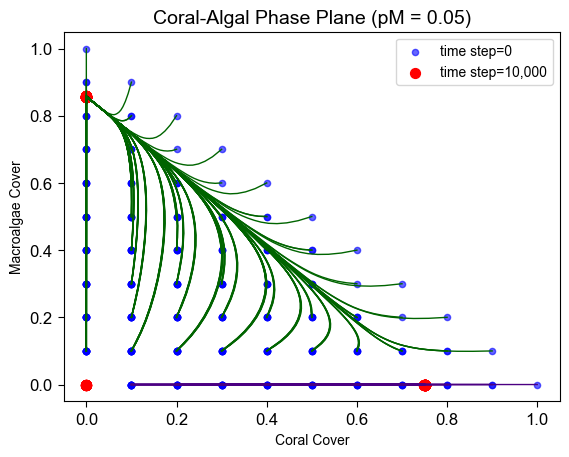

In [298]:
plotPhPl(df_AltSS_pM, 0.05)
#plt.savefig("BaselineBenthos_pM=05.png")

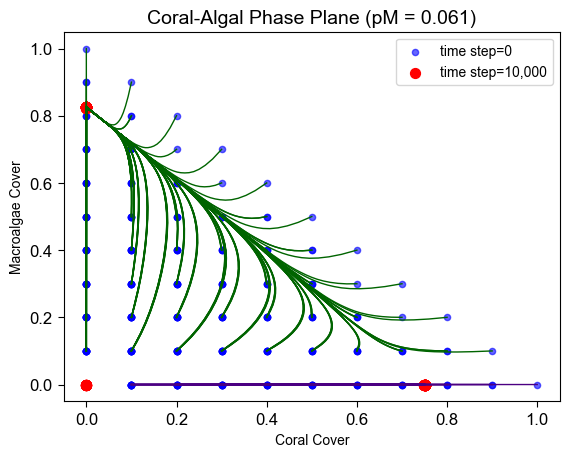

In [308]:
plotPhPl(df_AltSS_pM, 0.061111111111111116)
#plt.savefig("BaselineBenthos_pM=06.png")

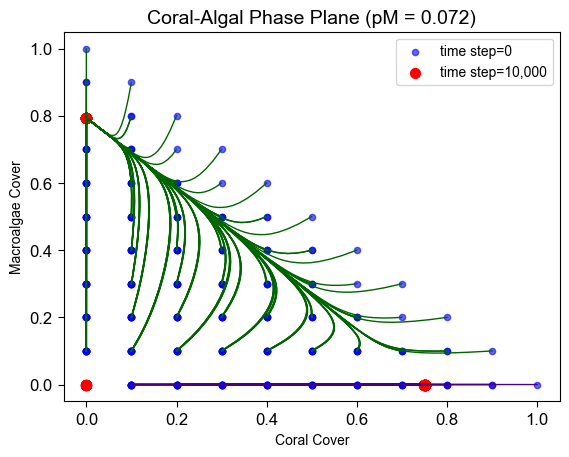

In [310]:
plotPhPl(df_AltSS_pM, 0.07222222222222222)
#plt.savefig("BaselineBenthos_pM=07.png")

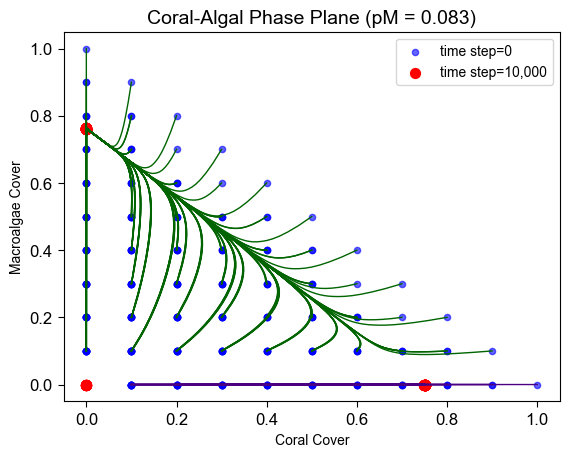

In [299]:
plotPhPl(df_AltSS_pM, 0.08333333333333333)
#plt.savefig("BaselineBenthos_pM=08.png")

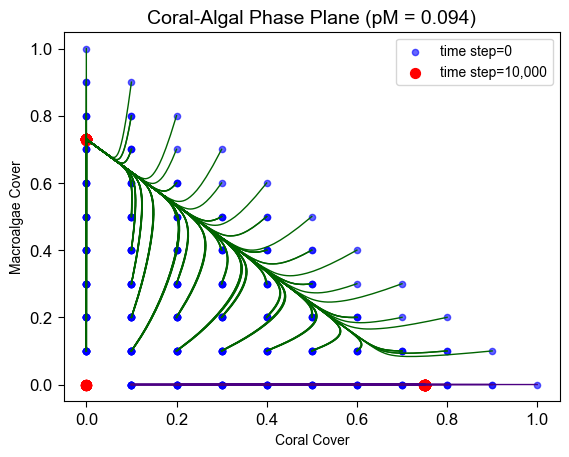

In [315]:
plotPhPl(df_AltSS_pM, 0.09444444444444444)
#plt.savefig("BaselineBenthos_pM=09.png")

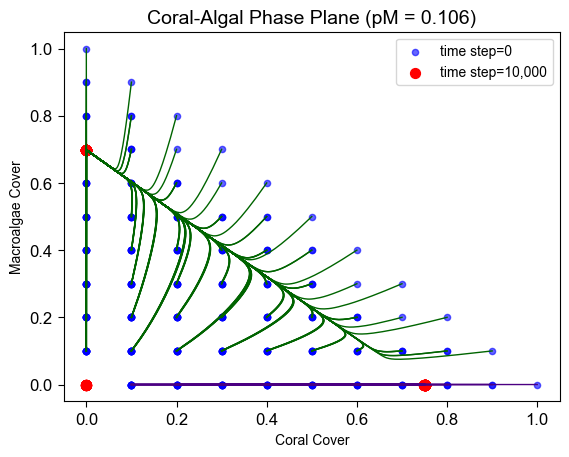

In [320]:
plotPhPl(df_AltSS_pM, 0.10555555555555556)
#plt.savefig("BaselineBenthos_pM=11.png")

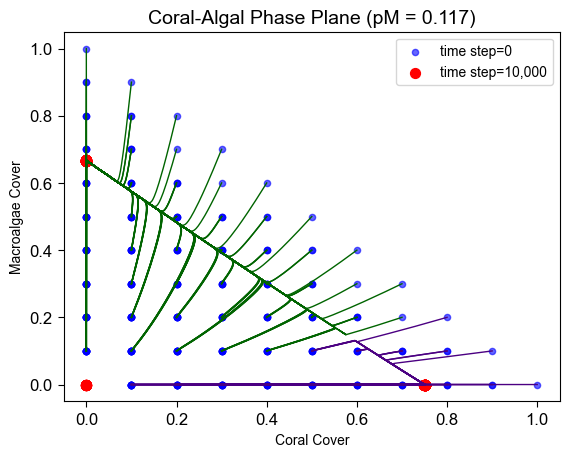

In [324]:
plotPhPl(df_AltSS_pM, 0.11666666666666665)
#plt.savefig("BaselineBenthos_pM=12.png")

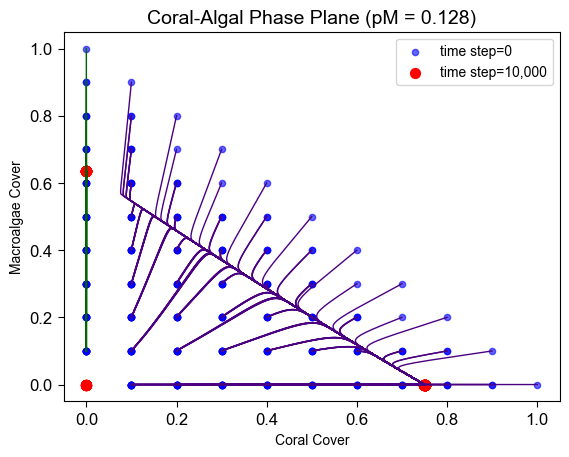

In [302]:
plotPhPl(df_AltSS_pM, 0.12777777777777777)
#plt.savefig("BaselineBenthos_pM=13.png")

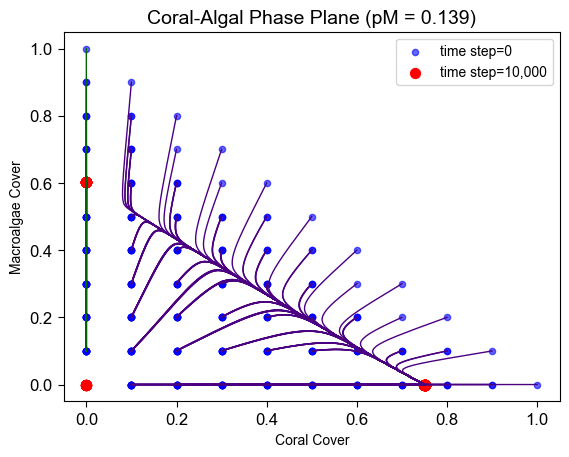

In [330]:
plotPhPl(df_AltSS_pM, 0.1388888888888889)
#plt.savefig("BaselineBenthos_pM=14.png")

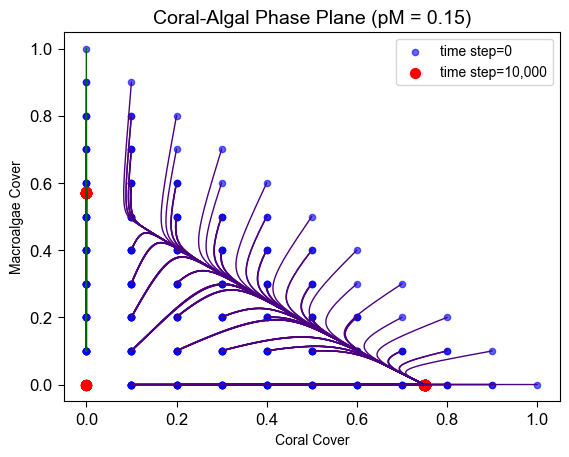

In [334]:
plotPhPl(df_AltSS_pM, 0.15)
#plt.savefig("BaselineBenthos_pM=15.png")

# Test for presence of AltSS across subrange of pM values

In [8]:
#for this run, you changed pM_val to pM_val_subrange in the AltSS_pM() function

start_time = time.perf_counter()

df_AltSS_pM_subrange = AltSS_pM()

end_time = time.perf_counter()
(end_time - start_time)/60

109.27720642500013

#### Save as excel file

In [ ]:
df_AltSS_pM_subrange

df_AltSS_pM_subrange[0].to_excel('timeseries_baseline benthos_varying pM_subrange.xlsx', index=False)
df_AltSS_pM_subrange[1].to_excel('equilibria__baseline benthos_varying pM_subrange.xlsx', index=False)

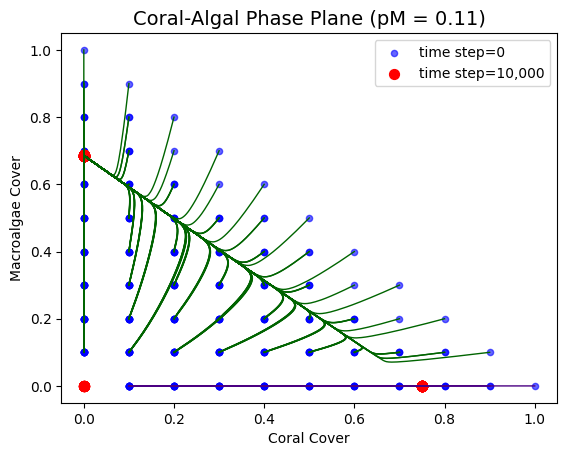

In [43]:
plotPhPl(df_3_sub, 0.11)
#plt.savefig("BaselineBenthos_pM=11_subrange.png")

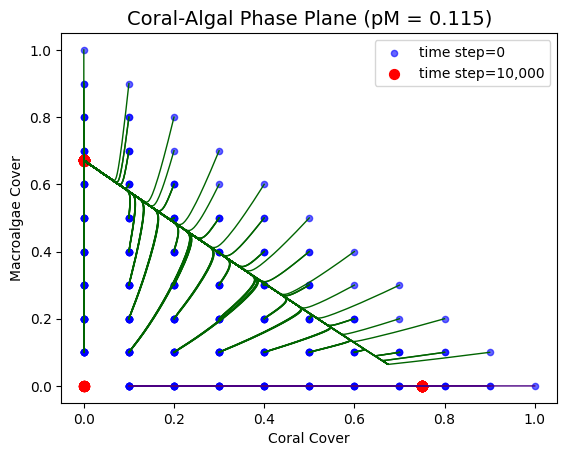

In [44]:
plotPhPl(df_3_sub, 0.115)
#plt.savefig("BaselineBenthos_pM=115_subrange.png")

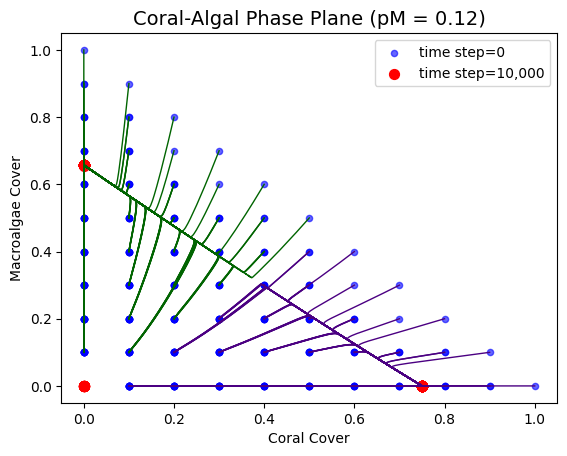

In [45]:
plotPhPl(df_3_sub, 0.12)
#plt.savefig("BaselineBenthos_pM=12_subrange.png")

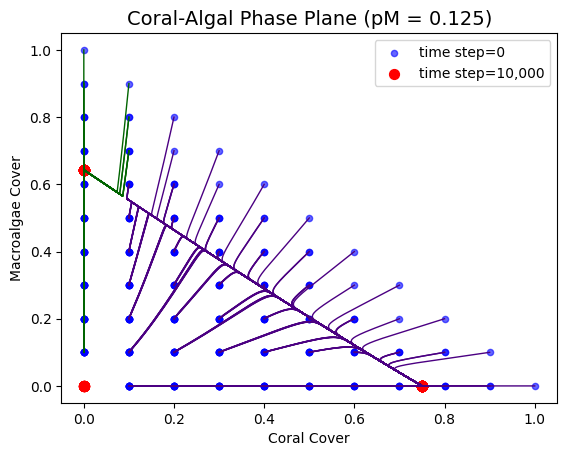

In [46]:
plotPhPl(df_3_sub, 0.125)
#plt.savefig("BaselineBenthos_pM=125_subrange.png")

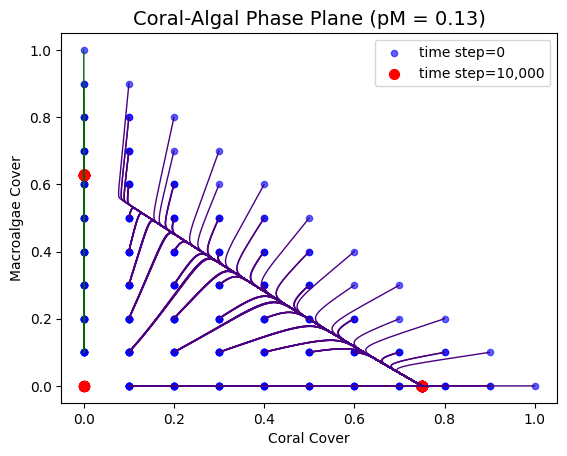

In [47]:
plotPhPl(df_3_sub, 0.13)
#plt.savefig("BaselineBenthos_pM=13_subrange.png")

#### Filter and plot

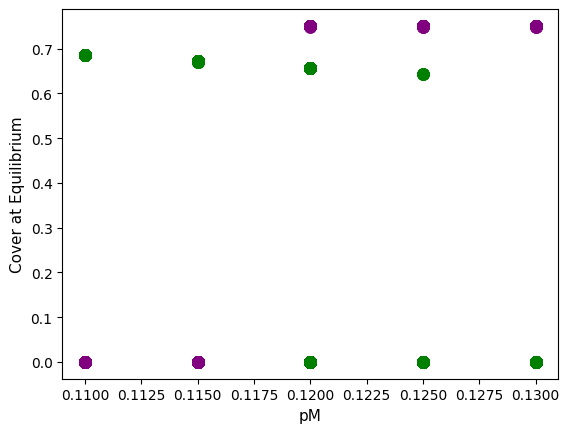

In [42]:
timeseries = pd.read_excel('timeseries_baseline benthos_varying pM_subrange.xlsx')
star = pd.read_excel('equilibria__baseline benthos_varying pM_subrange.xlsx')

x = len(timeseries)

for i in range(x): 
    if timeseries['C_array'][i][0] == 0:
        
        star = star.drop(i)
        
    elif timeseries['M_array'][i][0] == 0: 
        
        star = star.drop(i)    

star = star.reset_index(drop=True)

plt.scatter(star['pM'], star['C_prime'], c = 'purple', linestyle = 'dotted', linewidth=3)
plt.scatter(star['pM'], star['M_prime'], c = 'green', linestyle = 'dotted', linewidth=3)
plt.scatter(star['pM'], star['T_prime'], c = 'orange', linestyle = 'dotted', linewidth=3);